# Capston Project - Final Assignment

## Start of Step - 0

In [1]:
import pandas as pd
import numpy as np

# Libraries for web scraping
from bs4 import BeautifulSoup
import requests
import csv

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import matplotlib.cm as cm

%matplotlib inline

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-2.3.0               |        py36_1001         533 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         631 KB

The following NEW packages will be INSTALLED:

    altair:  2.3.0-py36_1001 conda-forge
    branca:  0.3.1-py_0      conda-forge
    folium:  0.5.0-py_0      conda-forge
    vincent: 0.4.4-py_1      conda-forge


vincent-0.4.4        | 28 KB     | #######################

### Use beautifulSoup package to scrape the web to read the data in Canada  

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source,'lxml')

In [3]:
# Function for crearting the dictionary with postal codes data scraped from web
def create_dict(lists):
    def inner_list(position):
        return [lists[i][position] for i, k in enumerate(lists)]
    
    dict_ = {}
    for i in range(1,4):
        l_ = inner_list(i)
        dict_.update({lists[0][i]:l_[1:]})
    return dict_

In [4]:
# Read the 'wikitable sortable' from web page in wikipedia
data_table = soup.find('table', class_='wikitable sortable')
data_row = data_table.find_all('tr')
    
l_ = [line.text.split('\n') for line in data_row]
l_dict = create_dict(l_)
df = pd.DataFrame(l_dict) # Create the dataframe from scraped data 

In [5]:
# Remove the rows with borough 'Not Assigned'
df = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [6]:
df.head() # The dataframe without 'Not assigned' Boroughs

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [7]:
## Replace all 'Not assigned' Neighborhoods with Borough
for i,r_ in df.iterrows():
    if r_['Neighbourhood'] == 'Not assigned':
            df.loc[i,'Neighbourhood'] = r_['Borough']

In [8]:
df.head() # The dataframe without 'Not assigned' Neighborhoods after setting 'Not assigned' Neighborhoods with Borough names

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


### Merging Neighbourhoods with common Postcodes and Boroughs as a comma seperated list

In [9]:
# if the value count>1 you need to merge the neighbourhood
def merge_nh(pc):
    cnt_ = df.groupby('Postcode').count()
    nh = cnt_['Neighbourhood'][pc]
    x_ = df[df.Postcode == pc]['Neighbourhood'].tolist()

    if nh > 1:      
        l_ = ','.join(x_)
    else:
        l_ = x_[0]
    return l_
 
k=[]
for i, row in df.iterrows():
    k.append(merge_nh(row['Postcode']))
    
df['Neighbourhood'] = k
df.drop_duplicates(keep='first',inplace=True)
df = df.reset_index(drop=True)

In [10]:
df.head() # The dataframe with comma seperated neighborhoods

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [11]:
df.shape # Shape of the dataframe

(103, 3)

### Retrieve the Geospatial data to merge with Postcode details

In [12]:
df_coords = pd.read_csv('http://cocl.us/Geospatial_data')
df_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
# Merging two dataframes on Postal Code
# Rename the Postal Code in coordinates data to Postcode
df_coords.rename(columns={'Postal Code':'Postcode'}, inplace=True)
df = pd.merge(df,df_coords,on='Postcode')

In [14]:
df.head() # Complete dataset with Postcodes and geospatial data

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


# Start of Analysis to solve the Capstone business Problem

## Start of Step - 1

**Setting up Foursquare credentials**

In [15]:
CLIENT_ID = 'NZG3JJSPA2TKFZTUGIITA3ZWMBHL45KKUSXBVUAJHNKONKYR' # Foursquare ID
CLIENT_SECRET = 'GZ33INJ512B130DIBZJ424041FTAXGMM3SIPZHRBCQWYTNTE' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NZG3JJSPA2TKFZTUGIITA3ZWMBHL45KKUSXBVUAJHNKONKYR
CLIENT_SECRET:GZ33INJ512B130DIBZJ424041FTAXGMM3SIPZHRBCQWYTNTE


**Get nearby venues to Adelaide,King,Richmond**

In [16]:
df.set_index('Postcode',inplace = True)

# Adelaide,King,Richmond latitude, longitude
adkn_lat = df.loc[['M5H'],['Latitude','Longitude']]['Latitude'][0]
adkn_lng = df.loc[['M5H'],['Latitude','Longitude']]['Longitude'][0]

In [17]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    adkn_lat, 
    adkn_lng, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=NZG3JJSPA2TKFZTUGIITA3ZWMBHL45KKUSXBVUAJHNKONKYR&client_secret=GZ33INJ512B130DIBZJ424041FTAXGMM3SIPZHRBCQWYTNTE&v=20180605&ll=43.65057120000001,-79.3845675&radius=500&limit=100'

## Start of Step - 2

In [18]:
results = requests.get(url).json()

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.id','venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,id,lat,lng
0,Four Seasons Centre for the Performing Arts,Concert Hall,4ad4c062f964a520e5f720e3,43.650609,-79.386280
1,Nathan Phillips Square,Plaza,4ad4c05ef964a520a6f620e3,43.652270,-79.383516
2,The Keg Steakhouse & Bar,Steakhouse,4ad69511f964a520e40721e3,43.649937,-79.384196
3,Shangri-La Toronto,Hotel,4e31b74252b131dcebb08743,43.649129,-79.386557
4,Cafe Landwer,Café,5b6c842bc36588002c80a934,43.648811,-79.385217


## Start of Step - 3

In [21]:
cnt = nearby_venues.groupby('categories').count()
cnt.sort_values('name',inplace=True, ascending=False)

In [22]:
cnt.head()

,name,id,lat,lng
categories,,,,
Coffee Shop,6,6,6,6
Café,5,5,5,5
American Restaurant,4,4,4,4
Thai Restaurant,4,4,4,4
Steakhouse,4,4,4,4


## Start of Step - 4

**Define a maximum threshold level over number of businesses to consider setting up - Read the comment in front of 'threshold' variable**

In [23]:
# Get the venue ids for all businesses satisfying the given business condition and filter out them in nearby_venues
threshold = 3  # We only consider setting up the businesses in a selected type only we have less than 3 business (threshold level) under given type in the neighbourhood .

cnt = cnt[cnt.name < threshold].head()  # For simplicity we only take the first 5 businesses to evaluate
# cnt = cnt[cnt.name < threshold]
venue_ids = [r_['id'] for i,r_ in nearby_venues.iterrows() if(r_['categories'] in cnt.index.get_values())]

nearby_venues = nearby_venues[nearby_venues['id'].isin(venue_ids)]
nearby_venues.reset_index(inplace=True,drop=True)
nearby_venues.head()

,name,categories,id,lat,lng
0,Pizzeria Libretto,Pizza Place,5462ac56498e128ccafe8fea,43.648334,-79.385111
1,JaBistro,Sushi Restaurant,509bb871e4b09c7ac93f6642,43.649687,-79.388090
2,The Burger's Priest,Burger Joint,5578720f498ee3b165b1f32b,43.648476,-79.387373
3,Fune Japanese Restaurant,Japanese Restaurant,4afa1f33f964a520e91622e3,43.648514,-79.386457
4,Pi Co.,Pizza Place,5a5a59c5a423620ec1dafd41,43.648651,-79.385874


In [24]:
cnt.head()

,name,id,lat,lng
categories,,,,
Pizza Place,2,2,2,2
Burger Joint,2,2,2,2
Sushi Restaurant,2,2,2,2
Japanese Restaurant,2,2,2,2
Bookstore,2,2,2,2


## Start of Step - 5

In [25]:
# Getting all the ratings for each business
x=[]
for i, r_ in nearby_venues.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(r_['id'], CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        x.append(result['response']['venue']['rating'])
    except:
        x.append('No Ratings Yet') 
nearby_venues['ratings'] = x

### Mark the different businesses on location map to visualize the landscape 

In [26]:
# All venues with corresponding ratings
nearby_venues.head()

,name,categories,id,lat,lng,ratings
0,Pizzeria Libretto,Pizza Place,5462ac56498e128ccafe8fea,43.648334,-79.385111,8.4
1,JaBistro,Sushi Restaurant,509bb871e4b09c7ac93f6642,43.649687,-79.388090,8.8
2,The Burger's Priest,Burger Joint,5578720f498ee3b165b1f32b,43.648476,-79.387373,8.4
3,Fune Japanese Restaurant,Japanese Restaurant,4afa1f33f964a520e91622e3,43.648514,-79.386457,8.1
4,Pi Co.,Pizza Place,5a5a59c5a423620ec1dafd41,43.648651,-79.385874,7.7


In [27]:
# create map of New York using latitude and longitude values
map_business = folium.Map(location=[adkn_lat, adkn_lng], zoom_start=17)

cat_count = cnt.shape[0]
x = np.arange(cat_count)
ys = [i+x+(i*x)**2 for i in range(cat_count)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
cnt['color_id'] = rainbow

# add markers to map
for name, category, lat, lng  in zip(nearby_venues['name'], nearby_venues['categories'],nearby_venues['lat'], nearby_venues['lng']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color= cnt.loc[category,'color_id'],
        fill=True,
        fill_color= cnt.loc[category,'color_id'],
        fill_opacity=0.7,
        parse_html=False).add_to(map_business)  
    
map_business


## Start of Step - 6

In [28]:
nearby_venues = nearby_venues.sort_values(by=['categories','ratings']).reset_index(drop=True)
nearby_venues.head()

,name,categories,id,lat,lng,ratings
0,Indigospirit,Bookstore,4b059c24f964a520c2df22e3,43.648350,-79.380347,7.7
1,Indigo,Bookstore,4b2a6eb8f964a52012a924e3,43.653515,-79.380696,8.6
2,Five Guys,Burger Joint,573b65fb498e9bcba6b1089a,43.648953,-79.381481,7.4
3,The Burger's Priest,Burger Joint,5578720f498ee3b165b1f32b,43.648476,-79.387373,8.4
4,Ematei 絵馬亭,Japanese Restaurant,4b11c75cf964a520728423e3,43.651156,-79.388990,7.8


## Start of Step - 7

In [29]:
ratings_data = nearby_venues[['name','categories','ratings']]

nearby_categories = ratings_data.copy()
nearby_categories = nearby_categories[['categories']]
nearby_categories.drop_duplicates(keep='first',inplace=True)
nearby_categories.reset_index(drop=True,inplace=True)

ratings_data.set_index('name',drop=True,inplace=True)

In [30]:
## Labelling the bars
def label_bar(ax):
    rects = ax.patches
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()   
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # Use Y value as label and format number with one decimal place
        label = "{}".format(y_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)

**Visualize the customer rating for each venue under different business types**

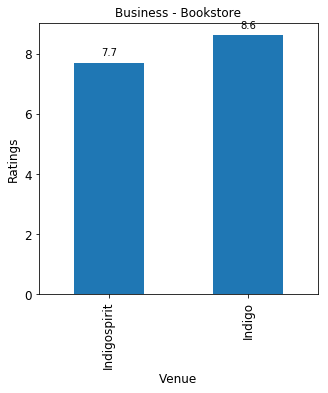

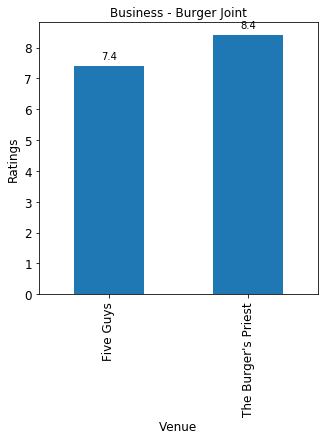

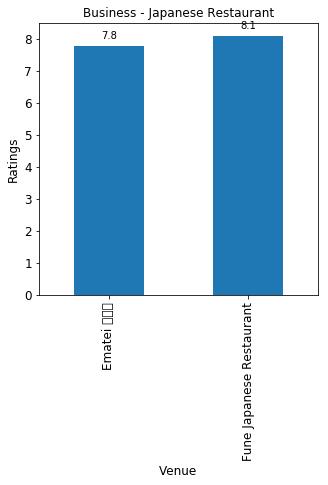

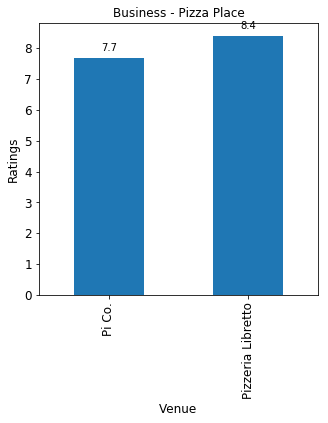

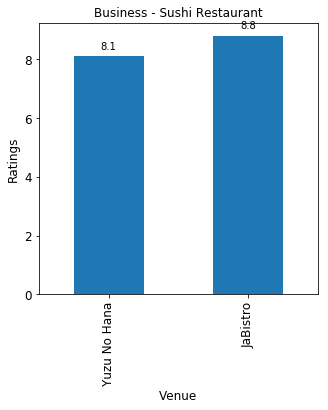

In [31]:
for i, r_ in nearby_categories.iterrows():
    plot_data = ratings_data[ratings_data.categories == r_['categories']]
    ax = plot_data.plot(kind='bar', title = 'Business - {}'.format(r_['categories']),figsize=(5,5),fontsize=12,use_index=True,legend=False)
    ax.set_xlabel('Venue',fontsize=12)
    ax.set_ylabel('Ratings',fontsize=12)
    label_bar(ax)
    
plt.show()

### End of Analysis